In [1]:
import os
import random
import import_ipynb

from BDAS_help import *

# pd.set_option('display.precision',12)

SEED = 722
# SEED = 123
random.seed(SEED)
np.random.seed(SEED)

importing Jupyter notebook from BDAS_help.ipynb


In [2]:
# ---- step 1 ----
file_dir = os.path.join('./','NZ-Vehicle-Fleet-Statistics-2018_web.xlsx')

In [3]:
# ---- step 2.1 2.2 ----
number_fleets_df = load_average_vehicle(file_dir)
light_fleet_age_df = load_light_fleet_age(file_dir)
co2_emission_df = load_co2_emission(file_dir)

In [4]:
# ---- step 2.3 ----
# number_fleets_df
# light_fleet_age_df
# co2_emission_df

In [5]:
# ---- step 2.4.1 ----
co2_emission_df = step_2_4_1_imputation_co2_emission_df(co2_emission_df)

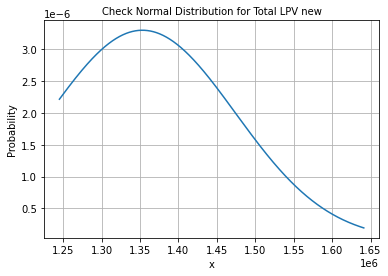

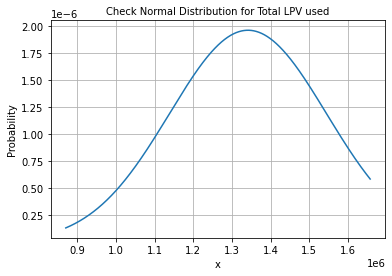

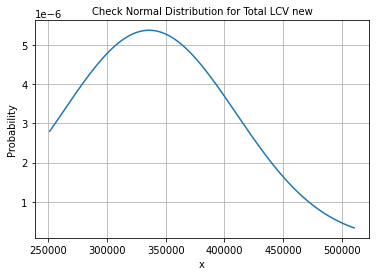

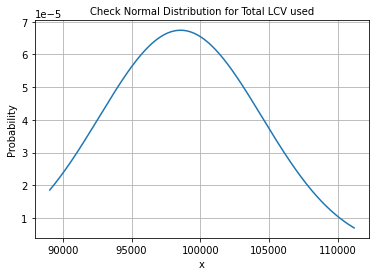

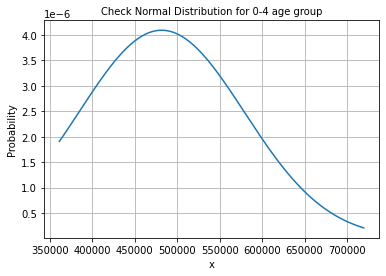

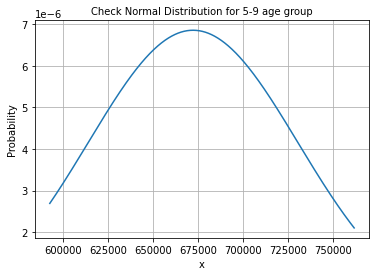

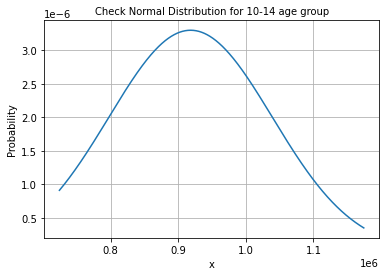

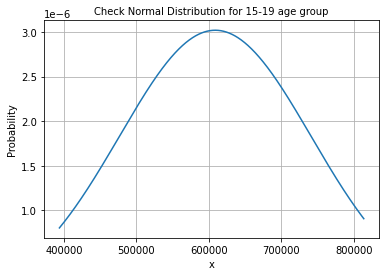

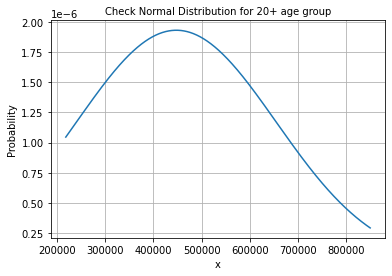

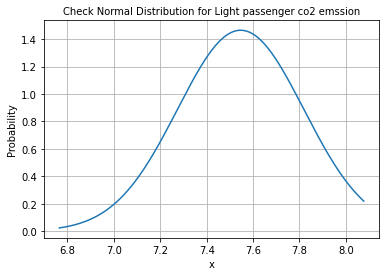

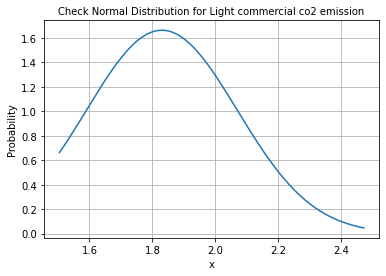

In [6]:
# ---- step 2.4.2 ----
step_2_4_2_check_normality(number_fleets_df, light_fleet_age_df, co2_emission_df)

In [7]:
 # ---- step 3.1 ----
num_fleets_select_cols = ['Period', 'Total light new', 'Total light used import', 'Total LPV new',
                              ' Total LPV used', 'Total LCV new', ' Total LCV used', 'Light passenger NZ new',
                              'Light passenger used import', 'Light commercial NZ New',
                              'Light commercial used import', 'Light fleet average age', 'Light passenger average age',
                              'Light commercial average age', 'Light used average age', 'NZ new light average age']
new_age_distribution_df = step_3_1_clean_light_age_distribution(light_fleet_age_df)
co2_select_cols = ['Light passenger', 'Light commercial']

In [8]:
# ---- step 3.2 ----
num_fleets_select_cols = ['Period', 'Total LPV new', ' Total LPV used', 'Total LCV new', ' Total LCV used',
                          'Light passenger average age', 'Light commercial average age']

percentage_columns = ['0-4 years percentage', '5-9 years  percentage','10-14 years percentage',
                      '15-19 years percentage', '20+ years percentage', '15+ years percentage']

In [9]:
# ---- step 3.3 ----
nums_columns = ['Total LPV new', ' Total LPV used', 'Total LCV new', ' Total LCV used']
new_age_distribution_df = step_3_3_construct_new_distribution_df(nums_columns, percentage_columns,
                                                                 number_fleets_df, new_age_distribution_df)
# new_age_distribution_df

In [10]:
# ---- step 3.4 ----
cleaned_data_df = pd.concat([number_fleets_df[num_fleets_select_cols], new_age_distribution_df,co2_emission_df[co2_select_cols]], axis=1)
# cleaned_data_df

In [11]:
# ---- step 3.5 ----
cleaned_data_df = step_3_5_convert_object_to_int(cleaned_data_df)

# sparkdf = spark.createDataFrame(cleaned_data_df)
# sparkdf.printSchema()

In [12]:
# ---- step 4.1 ----
# run PCA to select features
# step_4_1_LPV_cols(cleaned_data_df)
# step_4_1_LCV_cols(cleaned_data_df)

In [13]:
# ---- step 4.1 ----
reduced_LPV_cols = ['Total LPV new', ' Total LPV used', 'Light passenger average age','0-4 years of LPV new', '5-9 years of LPV new', 
                    '10-14 years of LPV new', '15-19 years of LPV new', '20+ years of LPV new', '0-4 years of LPV used', 
                    '5-9 years of LPV used', '10-14 years of LPV used', '15-19 years of LPV used', '20+ years of LPV used', 
                    'Light passenger']

reduced_LCV_cols = ['Total LCV new', ' Total LCV used', 'Light commercial average age', '0-4 years of LCV new', '5-9 years of LCV new',
                    '10-14 years of LCV new', '15-19 years of LCV new', '20+ years of LCV new', '0-4 years of LCV used', 
                    '5-9 years of LCV used', '10-14 years of LCV used', '15-19 years of LCV used', '20+ years of LCV used', 
                    'Light commercial']


In [14]:
# ---- step 4.2 ----
# example of normalization
# LPV_df, LCV_df = step_4_2_normalization(cleaned_data_df,reduced_LPV_cols,reduced_LCV_cols)
LPV_df, LCV_df = cleaned_data_df[reduced_LPV_cols],cleaned_data_df[reduced_LCV_cols]

In [15]:
# ---- step 5 ----
# explained match objectives with machine learning algorithms in report

In [46]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import FloatType

LPV_spark_df = spark.createDataFrame(LPV_df)

assembler = VectorAssembler(inputCols=LPV_spark_df.columns[:-1],outputCol="features")

LPV_assembler_df = assembler.transform(LPV_spark_df)

final_LPV_data = LPV_assembler_df.select('features','Light passenger')

train_data,test_data = final_LPV_data.randomSplit([0.7,0.3],seed=SEED)


                                 
noisy_df = spark.createDataFrame([[Vectors.dense(np.zeros(13)),0.0]])
train_data,test_data = train_data.union(noisy_df),test_data.union(noisy_df)

lr = LinearRegression(labelCol='Light passenger', regParam=0.2, elasticNetParam=0, loss='squaredError')
lrModel = lr.fit(train_data)

test_results = lrModel.evaluate(test_data)
test_results.residuals.show()
print("R2: %.4f"%(float(test_results.r2)))


+--------------------+
|           residuals|
+--------------------+
|-0.02497270997318246|
| 0.02852741727614294|
| -0.2735131455421653|
|-0.30165494386218583|
| -0.1431160011782537|
+--------------------+

R2: 0.9958


In [ ]:
# number_fleets_df = load_average_vehicle(file_dir)
# sparkDf = spark.createDataFrame(number_fleets_df)
# sparkDf.select("period","Total light new").show()
# sparkDf.show()